# Metaheurística aplicada ao TSP

**Desenvolvedor**: Vítor Gabriel Reis Caitité 

Nesse trabalho foi implementado um algoritmo genético (GA) para obtenção se soluções para o TSP.

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
import time 
from random import choice, choices
from random import sample
import random
import time
import operator

## Função para cálculo da matriz de distâncias

In [2]:
# Cálculo da matrix de distâncias considerando a distância euclideana
def calculate_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            d[l, c] = sqrt(sum((data[l] - data[c])**2))
    return d

# Cálculo da matrix de distâncias considerando a distância pseudo-euclideana
def calculate_pseudo_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            rij = sqrt(sum((data[l] - data[c])**2)/10.0)
            tij = round(rij)
            if tij < rij:
                dij = tij + 1
            else:
                dij = tij
            d[l, c] = dij
    return d

### Exemplo de matriz de distâncias para o problema berlin52

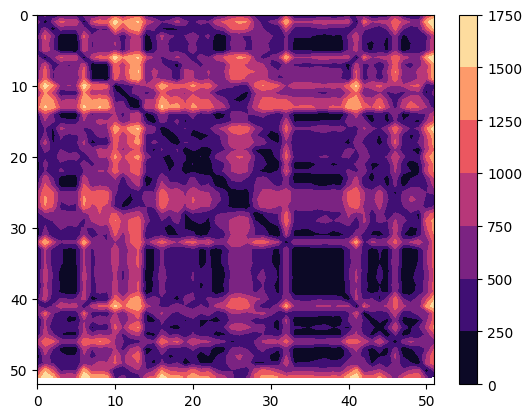

In [3]:
arquives_path = '~/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/instances/EUC_2D/'
df = pd.read_csv(f'{arquives_path}berlin52.tsp', skiprows=range(0, 6), sep='\s+', names=["X", "Y"], header=None) 
data = df.drop(df.tail(1).index, axis=0).to_numpy()
d = calculate_euc_distance_matrix(data)
plt.contourf(d, cmap='magma')
plt.ylim([data.shape[0], 0])
plt.colorbar()

## Nearest Neighbor (para geração da população inicial)

In [4]:
# Nearest neighbor for TSP:
def nearest_neighbor(distance_matrix, start):
    path = [start]  # variable to save the path
    cost = 0
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool) # to control which cities remain to visit   
    unvisited[start] = 0 
    for i in range(distance_matrix.shape[0]-1):
        last_city = path[-1]
        # finding the nearest neighbor for the last city:
        next_idx = np.argmin(distance_matrix[last_city][unvisited]) 
        next_city = np.arange(distance_matrix.shape[0])[unvisited][next_idx] 
        # adding the nearest neighbor to the path
        path.append(next_city)
        unvisited[next_city] = 0
        # Updating the cost
        cost += distance_matrix[last_city, next_city]
    # Updating the cost to add the cost from the lasst city to the first one.
    cost += distance_matrix[path[-1], path[0]]
    return path, cost

## Algoritimo Genético

In [5]:
class GA_for_tsp:
    
    def __init__(self, distance_matrix, pop_size, elitism_rate, mutation_rate, generations, \
                 k=3, selection_mode='tournament', initial_population='random'):
        self.distance_matrix = distance_matrix        
        self.pop_size = pop_size
        self.elite_size = int(elitism_rate*pop_size)
        self.mutation_rate = mutation_rate
        self.k = k
        self.generations = generations
        self.population = []
        self.selection_mode = selection_mode
        self.initial_population = initial_population
        
    def calculate_path_distance(self, path):
        cost = 0 
        for i in range(len(path)-1):
            cost += self.distance_matrix[path[i], path[i+1]]
        cost += self.distance_matrix[path[-1], path[0]] 
        return cost
    
    def fitness_function(self, path):
        return 1/self.calculate_path_distance(path)
    
    def create_path(self, start):
        if self.initial_population == 'random':
            n_cities = self.distance_matrix.shape[0]
            path = list(np.linspace(0, n_cities-1, n_cities, dtype=int))
            return sample(path, len(path))
        elif self.initial_population == 'nn':
            path, _ = nearest_neighbor(self.distance_matrix, start%self.distance_matrix.shape[0])
            return path

    def create_population(self):
        for i in range(0, self.pop_size):
            self.population.append(self.create_path(i))
            
    def tournament_selection(self, fitness_results):
        parents = choices(range(0,len(self.population)), k=self.k)
        parents = sorted(parents, key=lambda agent: fitness_results[agent], reverse=True)
        return parents[0] # return the tournament winning (with best cost)
    
    def roulette_wheel_selection(self, fitness_results):
        selection_probs = np.array(list(fitness_results.values()))/(sum(fitness_results.values())) 
        return np.random.choice(len(self.population), p=selection_probs)
        
    '''
    The purpose of selection is to select the fittest individuals 
    to let them pass their genes to the next generation.
    '''        
    def selection(self):
        fitness_results = {}
        # Calculate the firness for each tour:
        for idx in range(0, len(self.population)):
            fitness_results[idx] = self.fitness_function(self.population[idx])
        self.mean_fitness = np.array(list(fitness_results.values())).mean()
        # Selecting best paths. Elitism: the best individuals from the population 
        # will automatically carry over to the next generation,
        selected_idx = sorted(fitness_results.items(), key = operator.itemgetter(1), reverse = True)[0:self.elite_size]
        selected_idx = [x[0] for x in selected_idx]
        if self.selection_mode == 'tournament': 
            selection_algorithm = self.tournament_selection # Tournament Selection
        elif self.selection_mode == 'roulette': 
            selection_algorithm = self.roulette_wheel_selection # Roulette Wheel Selection
        for i in range(0, len(self.population) - self.elite_size):
            selected_idx.append(selection_algorithm(fitness_results))
        # Returning the selected elements (paths)
        selected = [self.population[idx] for idx in selected_idx]
        return selected
    
    def crossover(self, parent1, parent2):
        child = [None] * len(parent1)
        gene1 = int(random.random() * len(parent1))
        gene2 = int(random.random() * len(parent1))
        
        for idx in range(min(gene1, gene2), max(gene1, gene2)):
            child[idx] = parent1[idx]   
        i = 0    
        for idx in range(len(parent1)):
            if child[idx] is None:
                while parent2[i] in child:
                    i += 1
                child[idx] = parent2[i]
        return child
    
    def crossover_population(self, parents):
        children = []
        # Elitism:
        for idx in range(0, self.elite_size):
            children.append(parents[idx])
        parents_idx = sample(range(self.elite_size, len(parents)), len(parents)-self.elite_size)
        for idx in parents_idx:
            children.append(self.crossover(parents[idx], parents[(idx+1)%len(parents)]))
        return children
    
    def swap(self, individual):
        gene1, gene2 = np.random.choice(range(1,len(individual)), 2)
        v1 = min(gene1, gene2)
        v2 = max(gene1, gene2)
        individual[v1:v2] = individual[v2 - 1:v1 - 1:-1]
        return individual

    def mutate(self, children):
        next_population = []
        for child in children:
            if type(self.mutation_rate) is list:
                if self.fitness_function(child) < self.mean_fitness:
                    mutation_rate = max(self.mutation_rate)
                else:
                    mutation_rate = min(self.mutation_rate)
            else:
                mutation_rate = self.mutation_rate
            if random.random() <= mutation_rate:
                next_population.append(self.swap(child))
            else:
                next_population.append(child)
        return next_population
    
    def genetic_algorithm(self):
        self.create_population()    
        # Iterate over the generations
        for idx in range(0, self.generations):
            parents = self.selection()
            children = self.crossover_population(parents)
            self.population = self.mutate(children)
            
        fitness_results = np.zeros(len(self.population))
        for i in range(0, len(self.population)):
            fitness_results[i] = self.calculate_path_distance(self.population[i])       
        return np.min(fitness_results)

## Função para aplicação dos testes

In [6]:
def apply_test(arquives, n_tests):
    final_results = [["Arquivo", 'GA 1', 'GA 2']]
    final_time_results = [["Arquivo", 'GA 1', 'GA 2']]
    for arquive in arquives:
        print(arquive)
        df = pd.read_csv(f'{arquives_path}{arquive}', skiprows=range(0, 6), sep='\s+',                       names=["X", "Y"], header=None) 
        data = df.drop(df.tail(1).index, axis=0).to_numpy()
        if n_tests > data.shape[0]:
            n_tests = data.shape[0]
        if arquive == 'att48.tsp':
            d = calculate_pseudo_euc_distance_matrix(data)
        else:
            d = calculate_euc_distance_matrix(data)
        ga1_results = np.zeros(n_tests) 
        ga2_results = np.zeros(n_tests) 
        ga1_time_results = np.zeros(n_tests) 
        ga2_time_results = np.zeros(n_tests) 
        
        for idx in range(n_tests): 
            start_time = time.time()
            ga = GA_for_tsp(distance_matrix=d, pop_size=50, elitism_rate=0.15, mutation_rate=[0.2, 0.4], \
                            generations=3000, k=3, selection_mode = 'tournament', initial_population='nn')
            ga1_results[idx] = ga.genetic_algorithm()
            end_time = time.time()
            ga1_time_results[idx] = (end_time - start_time)*1000
            
            start_time = time.time()
            ga = GA_for_tsp(distance_matrix=d, pop_size=50, elitism_rate=0.15, mutation_rate=[0.2, 0.4], \
                            generations=3000, selection_mode = 'roulette', initial_population='nn')
            ga2_results[idx] = ga.genetic_algorithm()
            end_time = time.time()
            ga2_time_results[idx] = (end_time - start_time)*1000
            
        result = [arquive,
                 '{:.0f}'.format(ga1_results.mean()) + " +/- " + '{:.0f}'.format(ga1_results.std()),
                 '{:.0f}'.format(ga2_results.mean()) + " +/- " + '{:.0f}'.format(ga2_results.std())]
        
        time_result = [arquive,
                 '{:.1f}'.format(ga1_time_results.mean()) + " +/- " + '{:.1f}'.format(ga1_time_results.std()),
                 '{:.1f}'.format(ga2_time_results.mean()) + " +/- " + '{:.1f}'.format(ga2_time_results.std())]    
        final_results.append(result)
        print(result)
        final_time_results.append(time_result)
    return final_results, final_time_results

## Resultados

In [7]:
import os
import re
import tabulate
arquives = []
for root, dirs, files in os.walk('/home/vitor/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/instances'):
    for filename in files:
        if re.search(r'.tsp', filename):
            arquives.append(filename)
results, time_results = apply_test(arquives, 10)
# Generating table results:
table1 = tabulate.tabulate(results, tablefmt='grid')
table2 = tabulate.tabulate(time_results, tablefmt='grid')

kroA150.tsp
['kroA150.tsp', '29087 +/- 405', '30029 +/- 427']
kroB100.tsp
['kroB100.tsp', '23340 +/- 513', '23823 +/- 386']
pr107.tsp
['pr107.tsp', '45174 +/- 47', '45184 +/- 170']
kroC100.tsp
['kroC100.tsp', '21777 +/- 230', '22614 +/- 361']
rat99.tsp
['rat99.tsp', '1266 +/- 11', '1296 +/- 18']
st70.tsp
['st70.tsp', '710 +/- 6', '711 +/- 11']
kroB150.tsp
['kroB150.tsp', '28732 +/- 603', '30256 +/- 1187']
kroB200.tsp
['kroB200.tsp', '32669 +/- 527', '34632 +/- 689']
pr136.tsp
['pr136.tsp', '106259 +/- 942', '107674 +/- 2208']
pr144.tsp
['pr144.tsp', '60765 +/- 16', '60782 +/- 56']
pr124.tsp
['pr124.tsp', '62153 +/- 1195', '62986 +/- 1459']
pr76.tsp
['pr76.tsp', '114029 +/- 1695', '118220 +/- 3335']
kroD100.tsp
['kroD100.tsp', '23372 +/- 183', '23945 +/- 600']
kroA200.tsp
['kroA200.tsp', '31877 +/- 472', '34430 +/- 623']
kroE100.tsp
['kroE100.tsp', '23301 +/- 285', '23617 +/- 289']
lin105.tsp
['lin105.tsp', '15893 +/- 330', '16250 +/- 377']
rat195.tsp
['rat195.tsp', '2479 +/- 24', '2734

### Custo obtido por cada algoritmo em cada arquivo de teste.

In [8]:
print(table1)

+--------------+-----------------+-----------------+
| Arquivo      | GA 1            | GA 2            |
+--------------+-----------------+-----------------+
| kroA150.tsp  | 29087 +/- 405   | 30029 +/- 427   |
+--------------+-----------------+-----------------+
| kroB100.tsp  | 23340 +/- 513   | 23823 +/- 386   |
+--------------+-----------------+-----------------+
| pr107.tsp    | 45174 +/- 47    | 45184 +/- 170   |
+--------------+-----------------+-----------------+
| kroC100.tsp  | 21777 +/- 230   | 22614 +/- 361   |
+--------------+-----------------+-----------------+
| rat99.tsp    | 1266 +/- 11     | 1296 +/- 18     |
+--------------+-----------------+-----------------+
| st70.tsp     | 710 +/- 6       | 711 +/- 11      |
+--------------+-----------------+-----------------+
| kroB150.tsp  | 28732 +/- 603   | 30256 +/- 1187  |
+--------------+-----------------+-----------------+
| kroB200.tsp  | 32669 +/- 527   | 34632 +/- 689   |
+--------------+-----------------+------------

### Tempo de execução (ms) de cada algoritmo em cada arquivo de teste. Processador i7 7th Gen., 8 Gb de RAM, sistema Linux.

In [9]:
print(table2)

+--------------+----------------------+----------------------+
| Arquivo      | GA 1                 | GA 2                 |
+--------------+----------------------+----------------------+
| kroA150.tsp  | 134040.0 +/- 8178.2  | 139908.4 +/- 4517.9  |
+--------------+----------------------+----------------------+
| kroB100.tsp  | 65387.0 +/- 2487.4   | 69732.9 +/- 3363.7   |
+--------------+----------------------+----------------------+
| pr107.tsp    | 67056.3 +/- 3012.5   | 71435.5 +/- 1988.2   |
+--------------+----------------------+----------------------+
| kroC100.tsp  | 58097.6 +/- 625.4    | 63398.3 +/- 652.5    |
+--------------+----------------------+----------------------+
| rat99.tsp    | 58947.7 +/- 3166.4   | 64392.5 +/- 3982.2   |
+--------------+----------------------+----------------------+
| st70.tsp     | 34739.5 +/- 2612.9   | 40618.3 +/- 3346.9   |
+--------------+----------------------+----------------------+
| kroB150.tsp  | 134949.6 +/- 6182.9  | 141340.9 +/- 58